# Cell 1
# Circos-Style Money Flow Chord Diagram

This notebook builds a self-contained Circos-style chord diagram from Accumulation Score time series in a local database.

Constraints honored:
- No project modules are imported or modified.
- Database access is read-only (SELECT-only).
- No files are written or mutated; all outputs are in-notebook only.


In [211]:
# Cell 2
# Ticker groups (hardcoded)
SECTOR_CORE_TICKERS = [
    "XLF","KRE","XLK","SMH","XLI","XLY","XLE","XLV","XLP","XLU"
]

SECTOR_SUMMARY_TICKERS = [
    "XLE", "XLF", "XLK", "XLY", "XLP", "XLV", "XLU", "XLI", "XLC", "XLB", "XLRE", "SPY",
]

GLOBAL_MACRO_TICKERS = [
    "SPY","QQQ","TQQQ","IWM","VGK","EWJ","EFA","EEM","FXI","UUP","TLT","GLD","USO","VIXY"
]

COMMODITIES_TICKERS = [
    "GLD","SLV","GDX","USO","UNG","URA"
]

MAG8_TICKERS = [
    "AAPL","MSFT","NVDA","AMZN","GOOGL","META","TSLA","AVGO"
]

ENABLED_GROUPS = {
    "GLOBAL_MACRO": False,
    "MAG8": False,
    "SECTOR_SUMMARY": True,
    "SECTOR_CORE": False,
    "COMMODITIES": False,
}

# Controls
END_DATE = None                         # End of window; None = auto-detect max date in DB
FLOW_PERIOD_DAYS = 3                    # Trading-day window used for flows (start->end inside this window)
TOP_K_WINNERS = 8                       # Max winners by demand (positive delta) to include
TOP_K_LOSERS = 8                        # Max losers by supply (negative delta) to include
MIN_EDGE_FLOW = 0.0                     # Drop edges smaller than this flow (pre-strand)
DISTRIBUTION_MODE = "demand_weighted"   # "equal" or "demand_weighted" split from sources to winners
STRAND_UNIT = 10.0                       # Flow per strand; lower = more ribbons (denser)
AUTO_STRAND_SCALING = True              # Auto-increase STRAND_UNIT if strands explode
MAX_STRANDS = 50000                     # Hard cap for total strands after auto-scaling

# Chord + ring layout
METRIC_BAND_MODE = "proportional"       # "equal" = same band width per metric; "proportional" = band width by flow
MAX_EDGES_PER_METRIC = 40               # cap edges per metric to keep plot readable
CHORD_ARC_FRACTION = 1.0                # fraction of ticker arc reserved for chord endpoints
CHORD_RADIUS = 0.78                     # inner radius for chord ribbons
TIME_SLICE_BINS = 3                     # number of time slices per outer ring
RING_BASE_THICKNESS = 0.012             # minimum ring thickness
RING_THICKNESS_SCALE = 0.06             # added thickness scaled by magnitude
RING_GAP = 0.01                         # gap between metric rings
BAND_GAP_FRAC = 0.02                   # gap between metric bands within a ticker
DIR_GAP_FRAC = 0.02                     # gap between outflow/inflow halves inside a band
CATEGORY_GAP_DEG = 1                # degrees; category block gap (0 = uniform spacing)

# Render quality (performance vs fidelity)
RENDER_MODE = "balanced"  # "fast", "balanced", "quality"
CHORD_FILL_ALPHA = 0.55
CHORD_LINE_ALPHA = 0.8
CHORD_COLOR_SOFTEN = 0.25  # blend toward background to reduce saturation
if RENDER_MODE == "fast":
    USE_GRADIENT_FILL = False
    CHORD_GRADIENT_STEPS = 8
    CHORD_ARC_POINTS = 8
    CHORD_CURVE_POINTS = 30
elif RENDER_MODE == "quality":
    USE_GRADIENT_FILL = True
    CHORD_GRADIENT_STEPS = 32
    CHORD_ARC_POINTS = 18
    CHORD_CURVE_POINTS = 70
else:
    USE_GRADIENT_FILL = True
    CHORD_GRADIENT_STEPS = 18
    CHORD_ARC_POINTS = 12
    CHORD_CURVE_POINTS = 50

# Layer toggles
SHOW_ACCUM_FLOW = True
SHOW_LIT_FLOW = False
SHOW_SHORT_FLOW = False
SHOW_VOLUME_RING = True
SHOW_TICKER_ARC = True

In [212]:
# Cell 3
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import numpy as np

def find_db_candidates():
    root = Path('.').resolve()
    search_dirs = [
        root / 'data',
        root / 'darkpool_analysis' / 'data',
        root,
    ]
    patterns = ['*.duckdb', '*.db', '*.sqlite', '*.sqlite3']
    candidates = []
    for base in search_dirs:
        if not base.exists():
            continue
        for pattern in patterns:
            candidates.extend(list(base.rglob(pattern)))
    # Unique + files only
    unique = []
    seen = set()
    for p in candidates:
        if not p.is_file():
            continue
        if p in seen:
            continue
        seen.add(p)
        unique.append(p)
    unique.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return unique

def connect_db(db_path):
    db_path = Path(db_path)
    suffix = db_path.suffix.lower()
    errors = []

    def try_duckdb():
        import duckdb
        return duckdb.connect(database=str(db_path), read_only=True), 'duckdb'

    def try_sqlite():
        import sqlite3
        uri = f"file:{db_path.resolve().as_posix()}->mode=ro"
        return sqlite3.connect(uri, uri=True), 'sqlite'

    if suffix == '.duckdb':
        try:
            return try_duckdb()
        except Exception as e:
            errors.append(f'duckdb: {e}')
        try:
            return try_sqlite()
        except Exception as e:
            errors.append(f'sqlite: {e}')
    else:
        try:
            return try_sqlite()
        except Exception as e:
            errors.append(f'sqlite: {e}')
        try:
            return try_duckdb()
        except Exception as e:
            errors.append(f'duckdb: {e}')

    raise RuntimeError('Unable to open database. ' + '; '.join(errors))

def list_tables(conn, db_type):
    if db_type == 'duckdb':
        return [r[0] for r in conn.execute('SHOW TABLES').fetchall()]
    rows = conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()
    return [r[0] for r in rows]

def get_columns(conn, db_type, table):
    pragma = f'PRAGMA table_info("{table}")'
    rows = conn.execute(pragma).fetchall()
    # rows: (cid, name, type, notnull, dflt_value, pk)
    return [r[1] for r in rows]

def normalize_name(name):
    return ''.join([c for c in name.lower() if c.isalnum()])

def pick_column(columns, candidates):
    norm_map = {normalize_name(c): c for c in columns}
    for cand in candidates:
        cand_norm = normalize_name(cand)
        if cand_norm in norm_map:
            return norm_map[cand_norm]
    for cand in candidates:
        cand_norm = normalize_name(cand)
        for col_norm, original in norm_map.items():
            if cand_norm in col_norm:
                return original
    return None

def quote_ident(name):
    safe = name.replace('"', '""')
    return f'"{safe}"'

TICKER_COL_CANDIDATES = ['ticker', 'symbol', 'sym']
DATE_COL_CANDIDATES = ['date', 'trade_date', 'market_date', 'dt', 'day']
ACCUM_COL_CANDIDATES = [
    'accumulation_score', 'accum_score', 'accumulation', 'accum',
    'accumulation_score_display', 'accum_score_display'
]

db_candidates = find_db_candidates()
print('DB candidates (newest first):')
for p in db_candidates:
    print(' -', p)

if not db_candidates:
    print('No database files found under ./data or ./darkpool_analysis/data.')
    raise SystemExit

DB_PATH = db_candidates[0]
print(f'Selected DB: {DB_PATH}')

conn, DB_TYPE = connect_db(DB_PATH)
print(f'Detected DB type: {DB_TYPE}')

tables = list_tables(conn, DB_TYPE)
print(f'Found {len(tables)} tables.')

scan_rows = []
for table in tables:
    try:
        cols = get_columns(conn, DB_TYPE, table)
    except Exception as e:
        scan_rows.append({
            'table': table,
            'ticker_col': None,
            'date_col': None,
            'accum_col': None,
            'row_count': None,
            'distinct_tickers': None,
            'error': str(e),
        })
        continue

    ticker_col = pick_column(cols, TICKER_COL_CANDIDATES)
    date_col = pick_column(cols, DATE_COL_CANDIDATES)
    accum_col = pick_column(cols, ACCUM_COL_CANDIDATES)

    row_count = None
    distinct_tickers = None
    if ticker_col and date_col and accum_col:
        try:
            row_count = conn.execute(
                f'SELECT COUNT(*) FROM {quote_ident(table)}'
            ).fetchone()[0]
            distinct_tickers = conn.execute(
                f'SELECT COUNT(DISTINCT {quote_ident(ticker_col)}) FROM {quote_ident(table)}'
            ).fetchone()[0]
        except Exception:
            pass

    scan_rows.append({
        'table': table,
        'ticker_col': ticker_col,
        'date_col': date_col,
        'accum_col': accum_col,
        'row_count': row_count,
        'distinct_tickers': distinct_tickers,
        'error': None,
    })

print('Scanned tables (ticker/date/accum detection):')
for row in scan_rows:
    print(
        f" - {row['table']}: ticker={row['ticker_col']} date={row['date_col']} accum={row['accum_col']} rows={row['row_count']} distinct_tickers={row['distinct_tickers']}"
    )

candidates = [r for r in scan_rows if r['ticker_col'] and r['date_col'] and r['accum_col']]
if not candidates:
    print('No tables matched the required ticker/date/accumulation schema.')
    conn.close()
    raise SystemExit

multi = [r for r in candidates if (r['distinct_tickers'] or 0) > 1]
pool = multi if multi else candidates
pool.sort(key=lambda r: (r['row_count'] or 0, r['distinct_tickers'] or 0), reverse=True)
best = pool[0]

SELECT_TABLE = best['table']
TICKER_COL = best['ticker_col']
DATE_COL = best['date_col']
ACCUM_COL = best['accum_col']

print('Selected table:')
print(f'  table={SELECT_TABLE}')
print(f'  ticker_col={TICKER_COL}, date_col={DATE_COL}, accum_col={ACCUM_COL}')

conn.close()


DB candidates (newest first):
 - C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Selected DB: C:\Users\fvign\Dropbox\Vscode\darkpool\darkpool_analysis\data\darkpool.duckdb
Detected DB type: duckdb
Found 13 tables.
Scanned tables (ticker/date/accum detection):
 - composite_signal: ticker=symbol date=date accum=None rows=None distinct_tickers=None
 - daily_metrics: ticker=symbol date=date accum=accumulation_score rows=390 distinct_tickers=13
 - finra_otc_weekly_raw: ticker=symbol date=week_start_date accum=None rows=None distinct_tickers=None
 - finra_short_daily_all_raw: ticker=symbol date=trade_date accum=None rows=None distinct_tickers=None
 - finra_short_daily_raw: ticker=symbol date=trade_date accum=None rows=None distinct_tickers=None
 - index_constituent_short_agg_daily: ticker=index_symbol date=trade_date accum=None rows=None distinct_tickers=None
 - lit_direction_daily: ticker=symbol date=date accum=None rows=None distinct_tickers=None
 - options_pr

In [213]:
# Cell 4
def build_ticker_universe():
    seen = set()
    ordered = []
    categories = {}
    enabled = globals().get("ENABLED_GROUPS", {})
    group_defs = [
        ("GLOBAL_MACRO", globals().get("GLOBAL_MACRO_TICKERS", [])),
        ("MAG8", globals().get("MAG8_TICKERS", [])),
        ("SECTOR_SUMMARY", globals().get("SECTOR_SUMMARY_TICKERS", [])),
        ("SECTOR_CORE", globals().get("SECTOR_CORE_TICKERS", [])),
        ("COMMODITIES", globals().get("COMMODITIES_TICKERS", [])),
    ]
    for group_name, tickers in group_defs:
        if not enabled.get(group_name, True):
            continue
        for t in tickers:
            if t not in seen:
                seen.add(t)
                ordered.append(t)
                categories[t] = group_name
    return ordered, categories


ticker_order, ticker_category = build_ticker_universe()
print("Ticker universe size:", len(ticker_order))
print("Enabled groups:", {k: v for k, v in ENABLED_GROUPS.items()})
ticker_list = [t.upper() for t in ticker_order]
import re

conn, DB_TYPE = connect_db(DB_PATH)

if DB_TYPE == 'duckdb':
    date_expr = f"CAST({quote_ident(DATE_COL)} AS DATE)"
    accum_expr = f"{quote_ident(ACCUM_COL)}"
else:
    date_expr = f"DATE({quote_ident(DATE_COL)})"
    accum_expr = f"{quote_ident(ACCUM_COL)}"

placeholders = ','.join(['?'] * len(ticker_list))
query = (
    f"SELECT UPPER({quote_ident(TICKER_COL)}) AS ticker, "
    f"{date_expr} AS date, {accum_expr} AS accumulation_score "
    f"FROM {quote_ident(SELECT_TABLE)} "
    f"WHERE UPPER({quote_ident(TICKER_COL)}) IN ({placeholders})"
)

print(f"Using accumulation table: {SELECT_TABLE} (ticker={TICKER_COL}, date={DATE_COL}, accum={ACCUM_COL})")

try:
    if DB_TYPE == 'duckdb':
        df_raw = conn.execute(query, ticker_list).df()
    else:
        df_raw = pd.read_sql_query(query, conn, params=ticker_list)
finally:
    conn.close()

if df_raw.empty:
    print('No data returned for the specified tickers.')
    raise SystemExit

print("Accumulation rows loaded:", len(df_raw))
print("Accumulation table date range:", df_raw["date"].min(), "->", df_raw["date"].max())
print("Accumulation raw sample:", df_raw["accumulation_score"].head(5).tolist())
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce').dt.date
df_raw['ticker'] = df_raw['ticker'].str.upper()

def fetch_accum_column(accum_col_name):
    conn, db_type = connect_db(DB_PATH)
    try:
        if db_type == 'duckdb':
            date_expr = f"CAST({quote_ident(DATE_COL)} AS DATE)"
        else:
            date_expr = f"DATE({quote_ident(DATE_COL)})"
        query = (
            f"SELECT UPPER({quote_ident(TICKER_COL)}) AS ticker, "
            f"{date_expr} AS date, {quote_ident(accum_col_name)} AS accumulation_score "
            f"FROM {quote_ident(SELECT_TABLE)} "
            f"WHERE UPPER({quote_ident(TICKER_COL)}) IN ({placeholders})"
        )
        if db_type == 'duckdb':
            return conn.execute(query, ticker_list).df()
        return pd.read_sql_query(query, conn, params=ticker_list)
    finally:
        conn.close()

def normalize_accum_df(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.date
    df['ticker'] = df['ticker'].str.upper()
    df['accumulation_score'] = df['accumulation_score'].apply(parse_accum)
    return df.dropna(subset=['date', 'accumulation_score'])

def parse_accum(value):
    if value is None:
        return np.nan
    if isinstance(value, (int, float, np.number)):
        if np.isnan(value):
            return np.nan
        return float(value)
    s = str(value).strip()
    if not s:
        return np.nan
    s = s.replace('%', '').replace(',', '')
    m = re.search(r'-->\d+(->:\.\d+)->', s)
    return float(m.group(0)) if m else np.nan

df_raw = normalize_accum_df(df_raw)
ACCUM_COL_SELECTED = ACCUM_COL
if df_raw.empty:
    print('Primary accumulation column returned no usable values; trying fallbacks...')
    conn, db_type = connect_db(DB_PATH)
    try:
        cols = get_columns(conn, db_type, SELECT_TABLE)
    finally:
        conn.close()
    candidates = []
    for cand in [
        'accumulation_score_display', 'accum_score_display',
        'accumulation_score', 'accum_score', 'accumulation', 'accum'
    ]:
        col = pick_column(cols, [cand])
        if col and col not in candidates:
            candidates.append(col)
    candidates = [c for c in candidates if c != ACCUM_COL]
    print('Accumulation fallback candidates:', candidates)
    for col in candidates:
        print('Trying accumulation column:', col)
        df_try = fetch_accum_column(col)
        print('Fallback rows loaded:', len(df_try))
        print('Fallback raw sample:', df_try['accumulation_score'].head(5).tolist())
        df_try = normalize_accum_df(df_try)
        if not df_try.empty:
            ACCUM_COL_SELECTED = col
            df_raw = df_try
            break

if df_raw.empty:
    print('All accumulation score rows are null after parsing.')
    raise SystemExit
print('Using accumulation column:', ACCUM_COL_SELECTED)

df_raw_full = df_raw.copy()

max_date = df_raw['date'].max()
if END_DATE is None or str(END_DATE).strip() == '':
    END_DATE_RESOLVED = max_date
else:
    END_DATE_RESOLVED = pd.to_datetime(END_DATE).date()
    if END_DATE_RESOLVED > max_date:
        print(f'END_DATE {END_DATE_RESOLVED} exceeds DB max date {max_date}; using max date.')
        END_DATE_RESOLVED = max_date

flow_days = int(FLOW_PERIOD_DAYS) if FLOW_PERIOD_DAYS and int(FLOW_PERIOD_DAYS) > 0 else 1
print("Flow period days:", flow_days, "END_DATE:", END_DATE_RESOLVED)

all_dates = sorted([d for d in df_raw["date"].unique() if pd.notna(d)])
end_dates = [d for d in all_dates if d <= END_DATE_RESOLVED]
window_dates = end_dates[-flow_days:]
if not window_dates:
    print("No dates available within FLOW_PERIOD_DAYS window.")
    raise SystemExit
print("Window date range used:", window_dates[0], "->", window_dates[-1], "count:", len(window_dates))
df_accum_daily = df_raw_full.sort_values(["ticker", "date"]).copy()
df_accum_daily["accum_net"] = df_accum_daily.groupby("ticker")["accumulation_score"].diff()
df_accum_daily["accum_net"] = df_accum_daily["accum_net"].fillna(0.0)
df_accum_daily = df_accum_daily[df_accum_daily["date"].isin(window_dates)][["ticker", "date", "accum_net"]]
df_raw = df_raw[df_raw["date"].isin(window_dates)]
print("Accumulation window rows:", len(df_raw))
missing = sorted(set(ticker_list) - set(df_raw["ticker"].unique()))
if missing:
    print("Missing tickers in accumulation window:", missing)
if df_raw.empty:
    print("No accumulation data within the selected window.")
    raise SystemExit


def tail_n(df_ticker, n, end_date):
    df = df_ticker[df_ticker['date'] <= end_date].sort_values('date')
    if df.empty:
        return df
    return df.tail(n)


rows = []
for ticker in ticker_order:
    df_t = df_raw[df_raw['ticker'] == ticker]
    tail = tail_n(df_t, flow_days, END_DATE_RESOLVED)
    if len(tail) < 2:
        a_start = None
        a_end = None
    else:
        a_start = float(tail['accumulation_score'].iloc[0])
        a_end = float(tail['accumulation_score'].iloc[-1])
    rows.append({
        'ticker': ticker,
        'category': ticker_category.get(ticker, 'UNKNOWN'),
        'A_end': a_end,
        'A_start': a_start,
        'end_date': END_DATE_RESOLVED,
        'start_date': tail['date'].iloc[0] if len(tail) else None,
        'samples': len(tail),
    })

df_scores = pd.DataFrame(rows)

# --- Volume data discovery (lit/short buy/sell) ---
LIT_BUY_CANDIDATES = ['lit_buy_volume', 'lit_buy_vol', 'lit_buy']
LIT_SELL_CANDIDATES = ['lit_sell_volume', 'lit_sell_vol', 'lit_sell']
SHORT_BUY_CANDIDATES = ['short_buy_volume', 'short_buy_vol', 'short_buy']
SHORT_SELL_CANDIDATES = ['short_sell_volume', 'short_sell_vol', 'short_sell']


def find_volume_table(conn, db_type):
    tables = list_tables(conn, db_type)
    candidates = []
    for table in tables:
        try:
            cols = get_columns(conn, db_type, table)
        except Exception:
            continue
        ticker_col = pick_column(cols, TICKER_COL_CANDIDATES)
        date_col = pick_column(cols, DATE_COL_CANDIDATES)
        lit_buy_col = pick_column(cols, LIT_BUY_CANDIDATES)
        lit_sell_col = pick_column(cols, LIT_SELL_CANDIDATES)
        short_buy_col = pick_column(cols, SHORT_BUY_CANDIDATES)
        short_sell_col = pick_column(cols, SHORT_SELL_CANDIDATES)
        if not (ticker_col and date_col and lit_buy_col and lit_sell_col and short_buy_col and short_sell_col):
            continue
        row_count = None
        distinct_tickers = None
        try:
            row_count = conn.execute(
                f'SELECT COUNT(*) FROM {quote_ident(table)}'
            ).fetchone()[0]
            distinct_tickers = conn.execute(
                f'SELECT COUNT(DISTINCT {quote_ident(ticker_col)}) FROM {quote_ident(table)}'
            ).fetchone()[0]
        except Exception:
            pass
        candidates.append({
            'table': table,
            'ticker_col': ticker_col,
            'date_col': date_col,
            'lit_buy_col': lit_buy_col,
            'lit_sell_col': lit_sell_col,
            'short_buy_col': short_buy_col,
            'short_sell_col': short_sell_col,
            'row_count': row_count,
            'distinct_tickers': distinct_tickers,
        })
    if not candidates:
        return None
    candidates.sort(key=lambda r: (r['row_count'] or 0, r['distinct_tickers'] or 0), reverse=True)
    return candidates[0]


conn, DB_TYPE = connect_db(DB_PATH)
try:
    volume_info = find_volume_table(conn, DB_TYPE)
finally:
    conn.close()

VOLUME_DATA_AVAILABLE = volume_info is not None
if VOLUME_DATA_AVAILABLE:
    print("Volume table selected:", volume_info["table"])
    print("Volume columns:", {k: volume_info[k] for k in ["ticker_col", "date_col", "lit_buy_col", "lit_sell_col", "short_buy_col", "short_sell_col"]})
else:
    print("No volume table found with lit/short buy/sell columns.")

if VOLUME_DATA_AVAILABLE:
    conn, DB_TYPE = connect_db(DB_PATH)
    try:
        if DB_TYPE == 'duckdb':
            date_expr = f"CAST({quote_ident(volume_info['date_col'])} AS DATE)"
            num_cast = "TRY_CAST"
        else:
            date_expr = f"DATE({quote_ident(volume_info['date_col'])})"
            num_cast = "CAST"

        query = (
            f"SELECT UPPER({quote_ident(volume_info['ticker_col'])}) AS ticker, "
            f"{date_expr} AS date, "
            f"{num_cast}({quote_ident(volume_info['lit_buy_col'])} AS DOUBLE) AS lit_buy, "
            f"{num_cast}({quote_ident(volume_info['lit_sell_col'])} AS DOUBLE) AS lit_sell, "
            f"{num_cast}({quote_ident(volume_info['short_buy_col'])} AS DOUBLE) AS short_buy, "
            f"{num_cast}({quote_ident(volume_info['short_sell_col'])} AS DOUBLE) AS short_sell "
            f"FROM {quote_ident(volume_info['table'])} "
            f"WHERE UPPER({quote_ident(volume_info['ticker_col'])}) IN ({placeholders})"
        )

        if DB_TYPE == 'duckdb':
            df_vol_raw = conn.execute(query, ticker_list).df()
        else:
            df_vol_raw = pd.read_sql_query(query, conn, params=ticker_list)
    finally:
        conn.close()

    df_vol_raw['date'] = pd.to_datetime(df_vol_raw['date'], errors='coerce').dt.date
    print('Volume table rows loaded:', len(df_vol_raw))
    print('Volume table date range:', df_vol_raw['date'].min(), '->', df_vol_raw['date'].max())
    df_vol_raw = df_vol_raw[df_vol_raw['date'].isin(window_dates)]
    print('Volume window date range:', df_vol_raw['date'].min(), '->', df_vol_raw['date'].max(), 'rows:', len(df_vol_raw))
    df_vol_raw['ticker'] = df_vol_raw['ticker'].str.upper()
    for col in ['lit_buy', 'lit_sell', 'short_buy', 'short_sell']:
        df_vol_raw[col] = pd.to_numeric(df_vol_raw[col], errors='coerce')
    df_vol_raw = df_vol_raw.dropna(subset=['date'])
    df_lit_daily = (
        df_vol_raw.groupby(['ticker', 'date'], as_index=False)
        .agg({'lit_buy': 'sum', 'lit_sell': 'sum'})
    )
    df_lit_daily['lit_net'] = df_lit_daily['lit_buy'] - df_lit_daily['lit_sell']
    df_short_daily = (
        df_vol_raw.groupby(['ticker', 'date'], as_index=False)
        .agg({'short_buy': 'sum', 'short_sell': 'sum'})
    )
    df_short_daily['short_net'] = df_short_daily['short_buy'] - df_short_daily['short_sell']

    vol_rows = []
    for ticker in ticker_order:
        df_t = df_vol_raw[df_vol_raw['ticker'] == ticker]
        tail = tail_n(df_t, flow_days, END_DATE_RESOLVED)
        if tail.empty:
            vol_rows.append({
                'ticker': ticker,
                'lit_buy_sum': None,
                'lit_sell_sum': None,
                'short_buy_sum': None,
                'short_sell_sum': None,
                'volume_samples': 0,
            })
            continue
        vol_rows.append({
            'ticker': ticker,
            'lit_buy_sum': float(tail['lit_buy'].sum(skipna=True)),
            'lit_sell_sum': float(tail['lit_sell'].sum(skipna=True)),
            'short_buy_sum': float(tail['short_buy'].sum(skipna=True)),
            'short_sell_sum': float(tail['short_sell'].sum(skipna=True)),
            'volume_samples': len(tail),
        })

    df_volume = pd.DataFrame(vol_rows)
    total_samples = int(df_volume['volume_samples'].sum()) if not df_volume.empty else 0
    lit_total = float(df_volume['lit_buy_sum'].fillna(0).sum() + df_volume['lit_sell_sum'].fillna(0).sum()) if not df_volume.empty else 0.0
    short_total = float(df_volume['short_buy_sum'].fillna(0).sum() + df_volume['short_sell_sum'].fillna(0).sum()) if not df_volume.empty else 0.0
    if total_samples == 0 or (lit_total == 0 and short_total == 0):
        print('Volume data missing for selected period. Lit/short chords require non-zero buy/sell volume data.')
        raise SystemExit
else:
    df_volume = pd.DataFrame(columns=[
        'ticker', 'lit_buy_sum', 'lit_sell_sum', 'short_buy_sum', 'short_sell_sum', 'volume_samples'
    ])


Ticker universe size: 12
Enabled groups: {'GLOBAL_MACRO': False, 'MAG8': False, 'SECTOR_SUMMARY': True, 'SECTOR_CORE': False, 'COMMODITIES': False}
Using accumulation table: daily_metrics (ticker=symbol, date=date, accum=accumulation_score)
Accumulation rows loaded: 360
Accumulation table date range: 2025-11-20 00:00:00 -> 2025-12-31 00:00:00
Accumulation raw sample: [nan, nan, nan, nan, 0.0645457301371098]
Using accumulation column: accumulation_score
Flow period days: 3 END_DATE: 2025-12-31
Window date range used: 2025-12-29 -> 2025-12-31 count: 3
Accumulation window rows: 36
Volume table selected: daily_metrics
Volume columns: {'ticker_col': 'symbol', 'date_col': 'date', 'lit_buy_col': 'lit_buy_volume', 'lit_sell_col': 'lit_sell_volume', 'short_buy_col': 'short_buy_volume', 'short_sell_col': 'short_sell_volume'}
Volume table rows loaded: 360
Volume table date range: 2025-11-20 -> 2025-12-31
Volume window date range: 2025-12-29 -> 2025-12-31 rows: 36


In [214]:
# Cell 5
def build_edges_from_value(df, value_col, top_k_winners, top_k_losers):
    df = df[['ticker', value_col]].dropna().copy()
    winners = df[df[value_col] > 0].nlargest(top_k_winners, value_col)
    losers = df[df[value_col] < 0].copy()
    losers['supply'] = -losers[value_col]
    losers = losers.nlargest(top_k_losers, 'supply')

    edges = []
    total_demand = winners[value_col].sum() if not winners.empty else 0.0
    total_supply = losers['supply'].sum() if not losers.empty else 0.0

    if winners.empty or losers.empty:
        return pd.DataFrame(edges), winners, losers, total_demand, total_supply

    if DISTRIBUTION_MODE not in {'equal', 'demand_weighted'}:
        raise ValueError('DISTRIBUTION_MODE must be "equal" or "demand_weighted"')

    if DISTRIBUTION_MODE == 'equal':
        for _, loser in losers.iterrows():
            flow_each = loser['supply'] / len(winners)
            for _, winner in winners.iterrows():
                if flow_each >= MIN_EDGE_FLOW:
                    edges.append({
                        'source': loser['ticker'],
                        'dest': winner['ticker'],
                        'flow': float(flow_each),
                    })
    else:
        if total_demand > 0:
            for _, loser in losers.iterrows():
                for _, winner in winners.iterrows():
                    flow = loser['supply'] * (winner[value_col] / total_demand)
                    if flow >= MIN_EDGE_FLOW:
                        edges.append({
                            'source': loser['ticker'],
                            'dest': winner['ticker'],
                            'flow': float(flow),
                        })

    edges_df = pd.DataFrame(edges)
    if not edges_df.empty:
        edges_df = edges_df.sort_values('flow', ascending=False).reset_index(drop=True)
    return edges_df, winners, losers, total_demand, total_supply


def compute_strand_unit(edges_df, base_unit, max_strands):
    base = base_unit if base_unit and base_unit > 0 else 1.0
    if edges_df.empty or not max_strands or max_strands <= 0:
        return base
    total_flow = edges_df['flow'].sum()
    if total_flow <= 0:
        return base
    return max(base, total_flow / max_strands)


def estimate_strands(edges_df, unit):
    if edges_df.empty:
        return 0
    u = unit if unit and unit > 0 else 1.0
    return int(np.maximum(1, np.floor(edges_df['flow'] / u)).sum())


def split_strands(edges_df, unit):
    strand_rows = []
    u = unit if unit and unit > 0 else 1.0
    for _, row in edges_df.iterrows():
        flow = row['flow']
        n = max(1, int(np.floor(flow / u)))
        weight = flow / n
        for _ in range(n):
            strand_rows.append({
                'source': row['source'],
                'dest': row['dest'],
                'flow': weight,
            })
    return pd.DataFrame(strand_rows)


print('Auto strand scaling:', AUTO_STRAND_SCALING, 'MAX_STRANDS:', MAX_STRANDS)

# Accumulation flow (average level over window, centered by mean)
if df_scores['A_end'].notna().any() and df_scores['A_start'].notna().any():
    df_scores['delta'] = df_scores['A_end'] - df_scores['A_start']
else:
    df_scores['delta'] = np.nan

df_accum_level = df_raw_full[df_raw_full['date'].isin(window_dates)][['ticker', 'date', 'accumulation_score']].copy()
if 'accum_avg' in df_scores.columns:
    df_scores = df_scores.drop(columns=['accum_avg', 'accum_centered'], errors='ignore')
if not df_accum_level.empty:
    df_accum_avg = df_accum_level.groupby('ticker')['accumulation_score'].mean()
    df_scores = df_scores.merge(df_accum_avg.rename('accum_avg'), on='ticker', how='left')
else:
    df_scores['accum_avg'] = np.nan

if df_scores['accum_avg'].notna().any():
    mean_level = df_scores['accum_avg'].mean()
    df_scores['accum_centered'] = df_scores['accum_avg'] - mean_level
else:
    df_scores['accum_centered'] = np.nan

accum_for_flow = df_scores['accum_centered']

df_scores['role'] = np.where(
    accum_for_flow > 0,
    'winner',
    np.where(accum_for_flow < 0, 'loser', 'neutral')
)

df_scores_sorted = df_scores.sort_values(
    by='accum_centered', key=lambda s: s.abs(), ascending=False
).reset_index(drop=True)

accum_edges_df, accum_winners, accum_losers, accum_demand, accum_supply = build_edges_from_value(
    df_scores, 'accum_centered', TOP_K_WINNERS, TOP_K_LOSERS
)
accum_unit = compute_strand_unit(accum_edges_df, STRAND_UNIT, MAX_STRANDS) if AUTO_STRAND_SCALING else STRAND_UNIT
accum_strands_df = split_strands(accum_edges_df, accum_unit)
print("Accum winners/losers:", len(accum_winners), len(accum_losers), "edges:", len(accum_edges_df))
print("Accum strand unit:", accum_unit, "estimated:", estimate_strands(accum_edges_df, accum_unit), "actual:", len(accum_strands_df))

# Lit and Short flows (net buy - sell)
if VOLUME_DATA_AVAILABLE and not df_volume.empty:
    df_volume = df_volume.copy()
    df_volume['lit_net'] = df_volume['lit_buy_sum'] - df_volume['lit_sell_sum']
    df_volume['short_net'] = df_volume['short_buy_sum'] - df_volume['short_sell_sum']

    lit_edges_df, lit_winners, lit_losers, lit_demand, lit_supply = build_edges_from_value(
        df_volume, 'lit_net', TOP_K_WINNERS, TOP_K_LOSERS
    )
    short_edges_df, short_winners, short_losers, short_demand, short_supply = build_edges_from_value(
        df_volume, 'short_net', TOP_K_WINNERS, TOP_K_LOSERS
    )

    lit_unit = compute_strand_unit(lit_edges_df, STRAND_UNIT, MAX_STRANDS) if AUTO_STRAND_SCALING else STRAND_UNIT
    short_unit = compute_strand_unit(short_edges_df, STRAND_UNIT, MAX_STRANDS) if AUTO_STRAND_SCALING else STRAND_UNIT

    lit_strands_df = split_strands(lit_edges_df, lit_unit)
    short_strands_df = split_strands(short_edges_df, short_unit)

    total_strands = len(accum_strands_df) + len(lit_strands_df) + len(short_strands_df)
    if total_strands > MAX_STRANDS * 2:
        print("WARNING: large strand count:", total_strands, "Consider increasing STRAND_UNIT or MAX_STRANDS.")

    print("Lit winners/losers:", len(lit_winners), len(lit_losers), "edges:", len(lit_edges_df))
    print("Short winners/losers:", len(short_winners), len(short_losers), "edges:", len(short_edges_df))
    print("Lit strand unit:", lit_unit, "estimated:", estimate_strands(lit_edges_df, lit_unit), "actual:", len(lit_strands_df))
    print("Short strand unit:", short_unit, "estimated:", estimate_strands(short_edges_df, short_unit), "actual:", len(short_strands_df))
else:
    lit_edges_df = pd.DataFrame()
    short_edges_df = pd.DataFrame()
    lit_strands_df = pd.DataFrame()
    short_strands_df = pd.DataFrame()
    lit_winners = pd.DataFrame()
    short_winners = pd.DataFrame()
    lit_losers = pd.DataFrame()
    short_losers = pd.DataFrame()
    lit_demand = lit_supply = 0.0
    short_demand = short_supply = 0.0


Auto strand scaling: True MAX_STRANDS: 50000
Accum winners/losers: 5 7 edges: 35
Accum strand unit: 10.0 estimated: 35 actual: 35
Lit winners/losers: 6 6 edges: 36
Short winners/losers: 8 2 edges: 16
Lit strand unit: 81.91922 estimated: 49980 actual: 49980
Short strand unit: 104.23098 estimated: 49993 actual: 49993


In [215]:
# Cell 6
display(df_scores_sorted[['ticker', 'category', 'A_end', 'A_start', 'accum_avg', 'accum_centered', 'role']])

if SHOW_ACCUM_FLOW:
    if accum_edges_df.empty:
        display(pd.DataFrame(columns=['source', 'dest', 'flow']))
    else:
        display(accum_edges_df[['source', 'dest', 'flow']])

print('Volume availability:', VOLUME_DATA_AVAILABLE, 'rows:', len(df_volume))
if VOLUME_DATA_AVAILABLE and not df_volume.empty:
    display(df_volume[['ticker', 'lit_buy_sum', 'lit_sell_sum', 'short_buy_sum', 'short_sell_sum']])
    if (df_volume['lit_buy_sum'].fillna(0).sum() == 0 and df_volume['lit_sell_sum'].fillna(0).sum() == 0):
        print('Note: lit volumes sum to zero across selected period.')
else:
    print('Volume data not available for lit/short buy/sell flows.')

summary_parts = [
    f'END_DATE={END_DATE_RESOLVED}',
    f'FLOW_PERIOD_DAYS={FLOW_PERIOD_DAYS}',
    f'accum_supply={accum_supply:.2f}',
    f'accum_demand={accum_demand:.2f}',
]
if SHOW_LIT_FLOW:
    summary_parts.append(f'lit_supply={lit_supply:.2f}')
    summary_parts.append(f'lit_demand={lit_demand:.2f}')
if SHOW_SHORT_FLOW:
    summary_parts.append(f'short_supply={short_supply:.2f}')
    summary_parts.append(f'short_demand={short_demand:.2f}')

summary_parts.append(f'accum_edges={len(accum_edges_df)}')
summary_parts.append(f'lit_edges={len(lit_edges_df)}')
summary_parts.append(f'short_edges={len(short_edges_df)}')
summary_parts.append(
    f'strands={len(accum_strands_df) + len(lit_strands_df) + len(short_strands_df)}'
)

print(' | '.join(summary_parts))


,ticker,category,A_end,A_start,accum_avg,accum_centered,role
0,XLE,SECTOR_SUMMARY,0.239872,0.681122,0.334671,0.398240,winner
1,XLF,SECTOR_SUMMARY,-0.471176,-0.499079,-0.415194,-0.351625,loser
2,XLI,SECTOR_SUMMARY,-0.204361,-0.323672,-0.206702,-0.143133,loser
3,XLC,SECTOR_SUMMARY,0.060651,0.213003,0.073057,0.136627,winner
4,XLV,SECTOR_SUMMARY,0.136142,0.177371,0.064660,0.128229,winner
5,XLU,SECTOR_SUMMARY,-0.494743,-0.176471,-0.185135,-0.121566,loser
6,XLP,SECTOR_SUMMARY,-0.075094,0.384373,0.035150,0.098720,winner
7,XLK,SECTOR_SUMMARY,-0.340537,-0.036476,-0.140098,-0.076528,loser
8,XLRE,SECTOR_SUMMARY,-0.317941,0.126883,-0.107600,-0.044030,loser
9,XLB,SECTOR_SUMMARY,0.053373,-0.344800,-0.100928,-0.037359,loser


,source,dest,flow
0,XLF,XLE,0.179477
1,XLI,XLE,0.073058
2,XLU,XLE,0.062050
3,XLF,XLC,0.061574
4,XLF,XLV,0.057790
5,XLF,XLP,0.044491
6,XLK,XLE,0.039062
7,XLI,XLC,0.025065
8,XLI,XLV,0.023524
9,XLRE,XLE,0.022474


Volume availability: True rows: 12


,ticker,lit_buy_sum,lit_sell_sum,short_buy_sum,short_sell_sum
0,XLE,12187655.0,9392343.0,13765240.0,6312100.0
1,XLF,11590401.0,11341700.0,9771327.0,13940051.0
2,XLK,3526149.0,4802189.0,3457046.0,3124057.0
3,XLY,1960270.0,2572063.0,2199123.0,1194096.0
4,XLP,3699811.0,3723831.0,3788064.0,1940440.0
5,XLV,2328009.0,2454736.0,2772763.0,1207461.0
6,XLU,4203315.0,6007767.0,5316540.0,6359365.0
7,XLI,1810956.0,2063885.0,2191203.0,1049797.0
8,XLC,2769393.0,1689621.0,1925475.0,1137209.0
9,XLB,2532922.0,2034715.0,2787059.0,1850716.0


END_DATE=2025-12-31 | FLOW_PERIOD_DAYS=3 | accum_supply=0.78 | accum_demand=0.78 | accum_edges=35 | lit_edges=36 | short_edges=16 | strands=100008


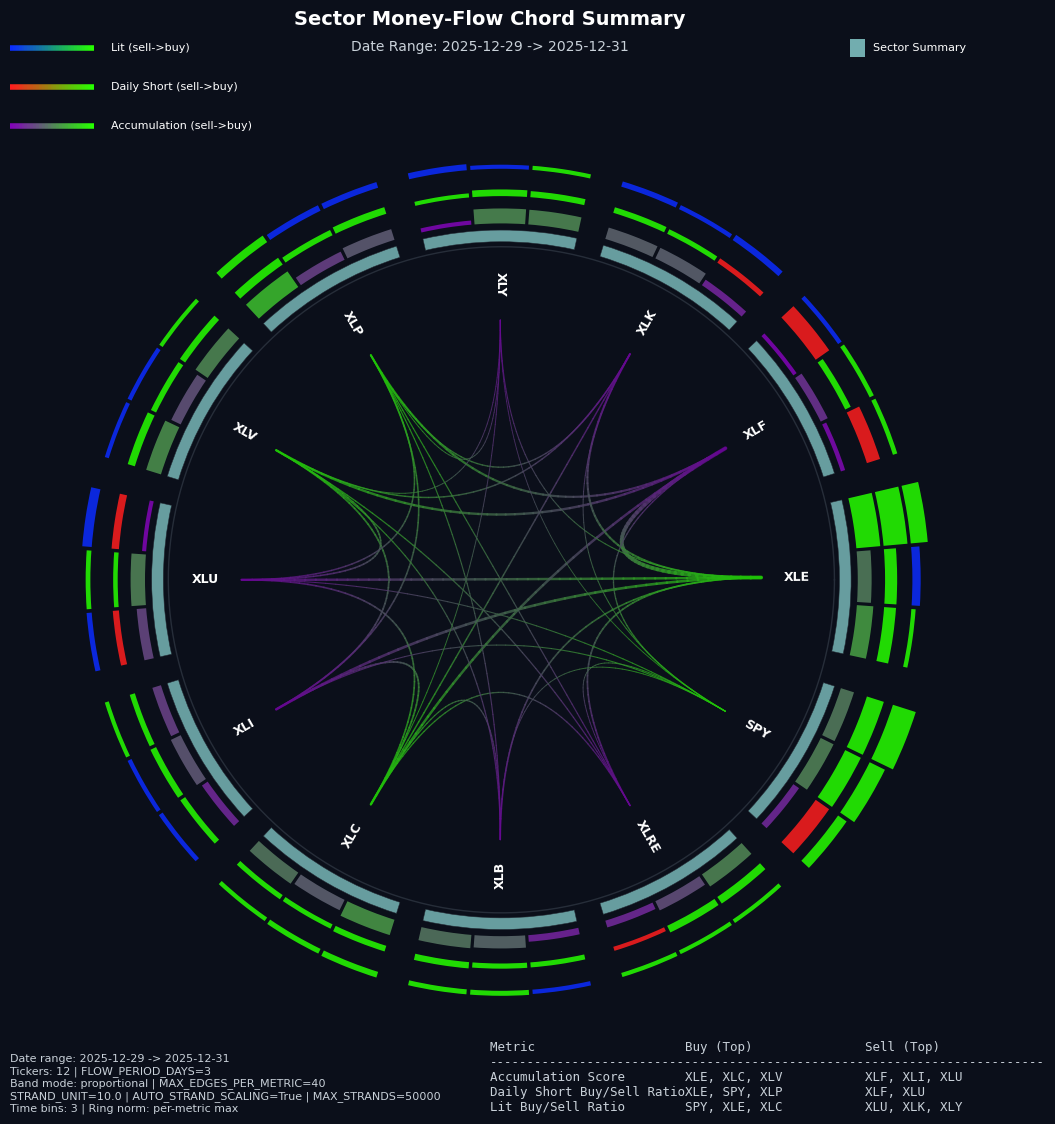

In [216]:
# Cell 7
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
from matplotlib.colors import to_rgba
from matplotlib.patches import Wedge, PathPatch, Rectangle
from matplotlib.path import Path

BG_COLOR = '#0b0f1a'

CATEGORY_LABELS = {
    'GLOBAL_MACRO': 'GLOBAL MACRO',
    'MAG8': 'MAG8',
    'SECTOR_SUMMARY': 'Sector Summary',
    'SECTOR_CORE': 'SECTORS',
    'COMMODITIES': 'COMMODITIES',
}
CATEGORY_PALETTE = {
    'GLOBAL_MACRO': "#00AAFF",
    'MAG8': '#DDA0FF',
    'SECTOR_SUMMARY': "#72ADAF",
    'SECTOR_CORE': '#F6C453',
    'COMMODITIES': '#7CDE8A',
    'UNKNOWN': '#A0A0A0',
}

METRIC_ORDER = ['accum', 'short', 'lit']
BAND_ORDER = ['lit', 'accum', 'short']  # left -> center -> right on each ticker
METRIC_LABELS = {
    'accum': 'Accumulation',
    'short': 'Daily Short',
    'lit': 'Lit',
}
METRIC_COLORS = {
    'accum': {'sell': "#8304B9", 'buy': "#26FF00"},
    'short': {'sell': "#FF1E1E", 'buy': "#26FF00"},
    'lit': {'sell': "#0B2CFF", 'buy': "#26FF00"},
}


def blend_color(c1, c2, t=0.5):
    a = np.array(to_rgba(c1))
    b = np.array(to_rgba(c2))
    return a * (1 - t) + b * t


def soften_color(color, amount, base=BG_COLOR):
    amt = max(0.0, min(1.0, amount))
    return blend_color(color, base, amt)


def add_gradient_curve(ax, points, color_start, color_end, lw, alpha):
    if len(points) < 2:
        return
    segments = np.stack([points[:-1], points[1:]], axis=1)
    c0 = np.array(to_rgba(color_start))
    c1 = np.array(to_rgba(color_end))
    t = np.linspace(0, 1, len(segments))[:, None]
    colors = c0 * (1 - t) + c1 * t
    colors[:, 3] = colors[:, 3] * alpha
    lc = LineCollection(segments, colors=colors, linewidths=lw, capstyle='round')
    ax.add_collection(lc)


def arc_points(a0, a1, r, n=None):
    count = n or CHORD_ARC_POINTS
    angles = np.linspace(a0, a1, count)
    return np.column_stack([r * np.cos(angles), r * np.sin(angles)])


def bezier_curve(p0, p1, p2, n=None):
    count = n or CHORD_CURVE_POINTS
    t = np.linspace(0, 1, count)[:, None]
    return (1 - t) ** 2 * p0 + 2 * (1 - t) * t * p1 + t ** 2 * p2


def ribbon_patch(a0, a1, b0, b1, r, color_start, color_end, alpha):
    arc1 = arc_points(a0, a1, r, n=16)
    arc2 = arc_points(b0, b1, r, n=16)
    curve1 = bezier_curve(arc1[-1], np.array([0.0, 0.0]), arc2[0], n=24)
    curve2 = bezier_curve(arc2[-1], np.array([0.0, 0.0]), arc1[0], n=24)
    poly = np.vstack([arc1, curve1, arc2, curve2])
    codes = [Path.MOVETO] + [Path.LINETO] * (len(poly) - 1)
    path = Path(poly, codes)
    mid = blend_color(color_start, color_end, 0.5)
    return PathPatch(path, facecolor=mid, edgecolor='none', alpha=alpha)


def gradient_fill_collection(a0, a1, b0, b1, r, color_start, color_end, alpha, steps=None):
    steps = steps or CHORD_GRADIENT_STEPS
    arc1 = arc_points(a0, a1, r, n=4)
    arc2 = arc_points(b0, b1, r, n=4)
    p_a0, p_a1 = arc1[0], arc1[-1]
    p_b0, p_b1 = arc2[0], arc2[-1]
    left = bezier_curve(p_a0, np.array([0.0, 0.0]), p_b0, n=steps + 1)
    right = bezier_curve(p_a1, np.array([0.0, 0.0]), p_b1, n=steps + 1)
    polys = []
    colors = []
    for i in range(steps):
        quad = np.vstack([left[i], left[i + 1], right[i + 1], right[i]])
        t = (i + 0.5) / steps
        color = blend_color(color_start, color_end, t)
        color[3] = color[3] * alpha
        polys.append(quad)
        colors.append(color)
    return PolyCollection(polys, facecolors=colors, edgecolors='none')


def draw_ribbon(ax, a0, a1, b0, b1, r, color_start, color_end, fill_alpha, line_alpha, lw):
    if USE_GRADIENT_FILL:
        clip = ribbon_patch(a0, a1, b0, b1, r, color_start, color_end, alpha=1.0)
        clip.set_facecolor('none')
        clip.set_edgecolor('none')
        ax.add_patch(clip)

        fill = gradient_fill_collection(a0, a1, b0, b1, r, color_start, color_end, fill_alpha)
        fill.set_clip_path(clip)
        ax.add_collection(fill)
    else:
        patch = ribbon_patch(a0, a1, b0, b1, r, color_start, color_end, alpha=fill_alpha)
        ax.add_patch(patch)

    mid_a = (a0 + a1) / 2
    mid_b = (b0 + b1) / 2
    p0 = np.array([r * np.cos(mid_a), r * np.sin(mid_a)])
    p2 = np.array([r * np.cos(mid_b), r * np.sin(mid_b)])
    center = np.array([0.0, 0.0])
    curve = bezier_curve(p0, center, p2)
    add_gradient_curve(ax, curve, color_start, color_end, lw=lw, alpha=line_alpha)


def make_time_bins(dates, bins):
    if not dates:
        return []
    if bins is None or bins <= 0:
        return [dates]
    bins = min(bins, len(dates))
    split = np.array_split(dates, bins)
    return [list(s) for s in split if len(s)]


def compute_metric_totals(edges_df):
    totals = {}
    if edges_df is None or edges_df.empty:
        return totals
    for row in edges_df.itertuples():
        totals[row.source] = totals.get(row.source, 0.0) + row.flow
        totals[row.dest] = totals.get(row.dest, 0.0) + row.flow
    return totals


def filter_edges(edges_df):
    if edges_df is None or edges_df.empty:
        return edges_df
    df = edges_df.copy()
    if MAX_EDGES_PER_METRIC and MAX_EDGES_PER_METRIC > 0:
        df = df.nlargest(MAX_EDGES_PER_METRIC, 'flow')
    return df


def allocate_intervals(edges_df, band_map, metric_key):
    if edges_df is None or edges_df.empty:
        return []
    out_totals = edges_df.groupby('source')['flow'].sum().to_dict()
    in_totals = edges_df.groupby('dest')['flow'].sum().to_dict()

    cursors_out = {}
    cursors_in = {}
    for ticker in ticker_order:
        spans = band_map.get(ticker, {}).get(metric_key)
        if not spans:
            continue
        cursors_out[ticker] = spans['out'][0]
        cursors_in[ticker] = spans['in'][0]

    intervals = []
    for row in edges_df.sort_values('flow', ascending=False).itertuples():
        src = row.source
        dst = row.dest
        flow = row.flow
        if src not in band_map or dst not in band_map:
            continue
        out_range = band_map[src][metric_key]['out']
        in_range = band_map[dst][metric_key]['in']
        if out_totals.get(src, 0.0) <= 0 or in_totals.get(dst, 0.0) <= 0:
            continue
        out_len = (out_range[1] - out_range[0]) * (flow / out_totals[src])
        in_len = (in_range[1] - in_range[0]) * (flow / in_totals[dst])
        a0 = cursors_out[src]
        a1 = min(out_range[1], a0 + out_len)
        b0 = cursors_in[dst]
        b1 = min(in_range[1], b0 + in_len)
        cursors_out[src] = a1
        cursors_in[dst] = b1
        if a1 > a0 and b1 > b0:
            intervals.append({'source': src, 'dest': dst, 'flow': flow, 'a0': a0, 'a1': a1, 'b0': b0, 'b1': b1})
    return intervals


# Prepare metric datasets
def metric_visible(metric_key):
    if metric_key == "accum":
        return SHOW_ACCUM_FLOW
    if metric_key == "short":
        return SHOW_SHORT_FLOW
    if metric_key == "lit":
        return SHOW_LIT_FLOW
    return True

accum_edges_plot = filter_edges(accum_edges_df)
short_edges_plot = filter_edges(short_edges_df)
lit_edges_plot = filter_edges(lit_edges_df)

metric_edges = {
    'accum': accum_edges_plot,
    'short': short_edges_plot,
    'lit': lit_edges_plot,
}

metric_nets = {
    'accum': df_scores.set_index('ticker')['accum_centered'].to_dict() if 'accum_centered' in df_scores.columns else df_scores.set_index('ticker')['delta'].to_dict(),
    'short': df_volume.set_index('ticker')['short_net'].to_dict() if 'short_net' in df_volume.columns else {},
    'lit': df_volume.set_index('ticker')['lit_net'].to_dict() if 'lit_net' in df_volume.columns else {},
}

df_accum_level = df_raw_full[df_raw_full['date'].isin(window_dates)][['ticker', 'date', 'accumulation_score']].copy()
if not df_accum_level.empty:
    df_accum_level = df_accum_level.rename(columns={'accumulation_score': 'value'})

metric_daily = {
    'accum': df_accum_level,
    'short': df_short_daily.rename(columns={'short_net': 'net'}),
    'lit': df_lit_daily.rename(columns={'lit_net': 'net'}),
}

# Build ticker layout (grouped by category, preserving order)
grouped = {
    'GLOBAL_MACRO': [t for t in ticker_order if ticker_category.get(t) == 'GLOBAL_MACRO'],
    'MAG8': [t for t in ticker_order if ticker_category.get(t) == 'MAG8'],
    'SECTOR_SUMMARY': [t for t in ticker_order if ticker_category.get(t) == 'SECTOR_SUMMARY'],
    'SECTOR_CORE': [t for t in ticker_order if ticker_category.get(t) == 'SECTOR_CORE'],
    'COMMODITIES': [t for t in ticker_order if ticker_category.get(t) == 'COMMODITIES'],
}

metric_totals = {m: compute_metric_totals(metric_edges[m]) for m in METRIC_ORDER}

total_nodes = sum(len(v) for v in grouped.values())
if total_nodes == 0:
    print('No nodes to plot.')
else:
    gap = math.radians(CATEGORY_GAP_DEG)
    total_gap = gap * len([g for g in grouped.values() if g])
    usable = 2 * math.pi - total_gap
    if usable <= 0:
        usable = 2 * math.pi
    step = usable / total_nodes
    arc_span = step * 0.85

    angles = {}
    spans = {}
    angle = 0.0
    for cat in ['GLOBAL_MACRO', 'MAG8', 'SECTOR_SUMMARY', 'SECTOR_CORE', 'COMMODITIES']:
        if not grouped[cat]:
            continue
        angle += gap / 2
        for t in grouped[cat]:
            angles[t] = angle
            spans[t] = (angle - arc_span / 2, angle + arc_span / 2)
            angle += step
        angle += gap / 2

    # Metric bands per ticker
    band_map = {}
    for t, (a0, a1) in spans.items():
        max_span = (a1 - a0)
        chord_span = min(max_span, max_span * CHORD_ARC_FRACTION)
        chord_center = (a0 + a1) / 2
        chord_start = chord_center - chord_span / 2
        chord_end = chord_center + chord_span / 2
        band_gap = chord_span * BAND_GAP_FRAC

        if METRIC_BAND_MODE == 'proportional':
            weights = {m: metric_totals[m].get(t, 0.0) for m in BAND_ORDER}
            if sum(weights.values()) <= 0:
                weights = {m: 1.0 for m in BAND_ORDER}
        else:
            weights = {m: 1.0 for m in BAND_ORDER}

        total_w = sum(weights.values())
        if total_w <= 0:
            weights = {m: 1.0 for m in BAND_ORDER}
            total_w = sum(weights.values())

        available = chord_span - band_gap * 2
        if available <= 0:
            band_gap = 0.0
            available = chord_span

        lengths = {m: max(0.0, available * (weights[m] / total_w)) for m in BAND_ORDER}
        acc_len = lengths.get('accum', available / 3)
        lit_len = lengths.get('lit', available / 3)
        short_len = lengths.get('short', available / 3)

        # Keep accumulation centered on the ticker arc; trim side bands if needed.
        max_acc = max(0.0, chord_span - 2 * band_gap)
        if acc_len > max_acc:
            acc_len = max_acc
        side_capacity = max(0.0, (chord_span - acc_len - 2 * band_gap) / 2)
        if side_capacity <= 0:
            lit_len = 0.0
            short_len = 0.0
        else:
            if lit_len > side_capacity or short_len > side_capacity:
                scale = min(1.0, side_capacity / max(lit_len, short_len))
                lit_len *= scale
                short_len *= scale

        acc_start = chord_center - acc_len / 2
        acc_end = chord_center + acc_len / 2
        lit_end = acc_start - band_gap
        lit_start = lit_end - lit_len
        short_start = acc_end + band_gap
        short_end = short_start + short_len

        def band_slices(start, end):
            dir_gap = (end - start) * DIR_GAP_FRAC
            dir_gap = min(dir_gap, (end - start) * 0.4)
            half = max(0.0, (end - start - dir_gap) / 2)
            out_start = start
            out_end = start + half
            in_start = out_end + dir_gap
            in_end = end
            return {
                'band': (start, end),
                'out': (out_start, out_end),
                'in': (in_start, in_end),
            }

        band_map[t] = {
            'lit': band_slices(lit_start, lit_end),
            'accum': band_slices(acc_start, acc_end),
            'short': band_slices(short_start, short_end),
        }

    # Prepare intervals per metric
    metric_intervals = {}
    for m in METRIC_ORDER:
        if not metric_visible(m):
            metric_intervals[m] = []
            continue
        metric_intervals[m] = allocate_intervals(metric_edges[m], band_map, m)

    # Time bins for outer ring
    window_dates_sorted = sorted(window_dates)
    time_bins = make_time_bins(window_dates_sorted, TIME_SLICE_BINS)
    time_bins = list(reversed(time_bins))

    # Pre-compute normalization for ring rendering
    metric_max_mag = {}
    metric_min_val = {}
    for m in METRIC_ORDER:
        df_m = metric_daily[m]
        if df_m is None or df_m.empty:
            metric_max_mag[m] = 1.0
            metric_min_val[m] = 0.0
            continue
        if m == 'accum' and 'value' in df_m.columns and df_m['value'].notna().any():
            metric_min_val[m] = float(df_m['value'].min())
            metric_max_mag[m] = float(df_m['value'].max())
        else:
            metric_min_val[m] = 0.0
            max_mag = float(df_m['net'].abs().max()) if df_m['net'].notna().any() else 1.0
            metric_max_mag[m] = max(1.0, max_mag)

    # Build bin value/net lookup
    metric_bin_net = {m: {} for m in METRIC_ORDER}
    for m in METRIC_ORDER:
        df_m = metric_daily[m]
        if df_m is None or df_m.empty:
            for t in ticker_order:
                metric_bin_net[m][t] = [0.0 for _ in time_bins]
            continue
        for t in ticker_order:
            net_by_bin = []
            for bin_dates in time_bins:
                mask = (df_m['ticker'] == t) & (df_m['date'].isin(bin_dates))
                if m == 'accum' and 'value' in df_m.columns:
                    val = float(df_m.loc[mask, 'value'].mean()) if mask.any() else 0.0
                    net_by_bin.append(val)
                else:
                    net = float(df_m.loc[mask, 'net'].sum()) if mask.any() else 0.0
                    net_by_bin.append(net)
            metric_bin_net[m][t] = net_by_bin

    # Start plot
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'aspect': 'equal'})
    fig.patch.set_facecolor(BG_COLOR)
    ax.set_facecolor(BG_COLOR)
    ax.axis('off')

    # Base circle
    theta = np.linspace(0, 2 * math.pi, 400)
    ax.plot(np.cos(theta), np.sin(theta), color='#39424e', lw=1.0, alpha=0.6)

    # Ticker arcs
    if SHOW_TICKER_ARC:
        ticker_outer = 1.05
        ticker_width = 0.035
        for t, (a0, a1) in spans.items():
            wedge = Wedge(
                (0, 0), ticker_outer, math.degrees(a0), math.degrees(a1),
                width=ticker_width,
                facecolor=CATEGORY_PALETTE.get(ticker_category.get(t, 'UNKNOWN'), '#A0A0A0'),
                edgecolor='#222831', lw=0.4, alpha=0.9,
            )
            ax.add_patch(wedge)
    else:
        ticker_outer = 1.02
        ticker_width = 0.02

    # Outer rings (time-sliced)
    if SHOW_VOLUME_RING:
        track_span = RING_BASE_THICKNESS + RING_THICKNESS_SCALE + RING_GAP
        for idx, m in enumerate(METRIC_ORDER):
            inner_base = ticker_outer + 0.02 + idx * track_span
            sell_color = METRIC_COLORS[m]['sell']
            buy_color = METRIC_COLORS[m]['buy']
            max_mag = metric_max_mag[m]
            for t, (a0, a1) in spans.items():
                bin_nets = metric_bin_net[m].get(t, [])
                if not bin_nets:
                    continue
                slice_gap = (a1 - a0) * 0.02
                total_slice = (a1 - a0) - slice_gap * (len(bin_nets) - 1)
                if total_slice <= 0:
                    total_slice = (a1 - a0)
                    slice_gap = 0.0
                slice_len = total_slice / len(bin_nets)
                cursor = a0
                for net in bin_nets:
                    if m == 'accum':
                        vmin = metric_min_val.get(m, 0.0)
                        vmax = metric_max_mag.get(m, 1.0)
                        denom = max(1e-9, vmax - vmin)
                        tnorm = max(0.0, min(1.0, (net - vmin) / denom))
                        thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * tnorm
                        color = blend_color(sell_color, buy_color, tnorm)
                    else:
                        mag = abs(net)
                        thickness = RING_BASE_THICKNESS + RING_THICKNESS_SCALE * (mag / max_mag if max_mag > 0 else 0.0)
                        color = buy_color if net >= 0 else sell_color
                    start_deg = math.degrees(cursor)
                    end_deg = math.degrees(cursor + slice_len)
                    wedge = Wedge(
                        (0, 0), inner_base + thickness, start_deg, end_deg,
                        width=thickness,
                        facecolor=color, edgecolor='none', alpha=0.85,
                    )
                    ax.add_patch(wedge)
                    cursor += slice_len + slice_gap

    # Draw chords per metric
    for m in METRIC_ORDER:
        if not metric_visible(m):
            continue
        intervals = metric_intervals[m]
        if not intervals:
            continue
        raw_start = METRIC_COLORS[m]['sell']
        raw_end = METRIC_COLORS[m]['buy']
        color_start = soften_color(raw_start, CHORD_COLOR_SOFTEN)
        color_end = soften_color(raw_end, CHORD_COLOR_SOFTEN)
        max_flow = metric_edges[m]['flow'].max() if metric_edges[m] is not None and not metric_edges[m].empty else 1.0
        for edge in intervals:
            flow = edge['flow']
            lw = 0.6 + 2.2 * ((flow / max_flow) ** 0.6) if max_flow > 0 else 1.0
            draw_ribbon(ax, edge['a0'], edge['a1'], edge['b0'], edge['b1'], CHORD_RADIUS, color_start, color_end, fill_alpha=CHORD_FILL_ALPHA, line_alpha=CHORD_LINE_ALPHA, lw=lw)

    # Ticker labels
    for t, ang in angles.items():
        x = math.cos(ang)
        y = math.sin(ang)
        r = CHORD_RADIUS + (ticker_outer - CHORD_RADIUS) * 0.4
        rot = math.degrees(ang)
        if math.pi / 2 < ang < 3 * math.pi / 2:
            rot += 180
        ax.text(
            r * x, r * y, t,
            color='#FFFFFF', fontsize=9, fontweight='bold',
            ha='center', va='center',
            rotation=rot, rotation_mode='anchor'
        )

    # Category labels
    for cat, tickers in grouped.items():
        if not tickers:
            continue
        if cat == 'SECTOR_SUMMARY':
            continue
        mid_angle = np.mean([angles[t] for t in tickers])
        ax.text(
            (ticker_outer + 0.4) * math.cos(mid_angle),
            (ticker_outer + 0.4) * math.sin(mid_angle),
            CATEGORY_LABELS.get(cat, cat),
            color=CATEGORY_PALETTE.get(cat, '#A0A0A0'),
            fontsize=12, fontweight='bold',
            ha='center', va='center'
        )

    # Title
    fig.text(0.5, 0.97, 'Sector Money-Flow Chord Summary', ha='center', va='top', color='white', fontsize=14, fontweight='bold')

    # Settings block
    date_range = f"{window_dates_sorted[0]} -> {window_dates_sorted[-1]}" if window_dates_sorted else 'n/a'
    fig.text(0.5, 0.945, f'Date Range: {date_range}', ha='center', va='top', color='#C9D1D9', fontsize=10)
    settings_lines = [
        f"Date range: {date_range}",
        f"Tickers: {len(ticker_order)} | FLOW_PERIOD_DAYS={FLOW_PERIOD_DAYS}",
        f"Band mode: {METRIC_BAND_MODE} | MAX_EDGES_PER_METRIC={MAX_EDGES_PER_METRIC}",
        f"STRAND_UNIT={STRAND_UNIT} | AUTO_STRAND_SCALING={AUTO_STRAND_SCALING} | MAX_STRANDS={MAX_STRANDS}",
        f"Time bins: {len(time_bins)} | Ring norm: per-metric max",
    ]
    settings = '\n'.join(settings_lines)
    fig.text(0.1, 0.05, settings, ha='left', va='bottom', color='#C9D1D9', fontsize=8)

    # Legend
    leg = fig.add_axes([0.1, 0.78, 0.28, 0.18])
    leg.axis('off')
    leg.set_facecolor('none')
    leg.set_xlim(0, 1)
    leg.set_ylim(0, 1)
    y = 0.88
    legend_order = ['lit', 'short', 'accum']
    for m in legend_order:
        xs = np.linspace(0.0, 0.25, 30)
        ys = np.full_like(xs, y)
        points = np.column_stack([xs, ys])
        segments = np.stack([points[:-1], points[1:]], axis=1)
        c0 = np.array(to_rgba(METRIC_COLORS[m]['sell']))
        c1 = np.array(to_rgba(METRIC_COLORS[m]['buy']))
        t = np.linspace(0, 1, len(segments))[:, None]
        colors = c0 * (1 - t) + c1 * t
        lc = LineCollection(segments, colors=colors, linewidths=4)
        leg.add_collection(lc)
        leg.text(0.3, y, f"{METRIC_LABELS[m]} (sell->buy)", color='white', fontsize=8, va='center')
        y -= 0.18

    # Category legend (top right)
    cat_leg = fig.add_axes([0.80, 0.78, 0.16, 0.18])
    cat_leg.axis('off')
    cat_leg.set_facecolor('none')
    cat_leg.set_xlim(0, 1)
    cat_leg.set_ylim(0, 1)
    cat_order = ['GLOBAL_MACRO', 'MAG8', 'SECTOR_SUMMARY', 'SECTOR_CORE', 'COMMODITIES']
    y = 0.88
    for cat in cat_order:
        if cat not in CATEGORY_PALETTE:
            continue
        if not grouped.get(cat):
            continue
        label = CATEGORY_LABELS.get(cat, cat)
        color = CATEGORY_PALETTE.get(cat, '#A0A0A0')
        cat_leg.add_patch(Rectangle((0.0, y - 0.04), 0.08, 0.08, facecolor=color, edgecolor='none'))
        cat_leg.text(0.12, y, label, color='white', fontsize=8, va='center')
        y -= 0.18

    # Top inflow/outflow callouts (table)
    def top_tickers(net_map, positive=True, k=3):
        if not net_map:
            return 'n/a'
        items = [(k, v) for k, v in net_map.items() if v is not None and np.isfinite(v)]
        if positive:
            items = [x for x in items if x[1] > 0]
            items = sorted(items, key=lambda x: x[1], reverse=True)
        else:
            items = [x for x in items if x[1] < 0]
            items = sorted(items, key=lambda x: x[1])
        tickers = [k for k, _ in items[:k]]
        return ', '.join(tickers) if tickers else 'n/a'

    table_rows = [
        ('Accumulation Score', top_tickers(metric_nets.get('accum', {}), True), top_tickers(metric_nets.get('accum', {}), False)),
        ('Daily Short Buy/Sell Ratio', top_tickers(metric_nets.get('short', {}), True), top_tickers(metric_nets.get('short', {}), False)),
        ('Lit Buy/Sell Ratio', top_tickers(metric_nets.get('lit', {}), True), top_tickers(metric_nets.get('lit', {}), False)),
    ]

    col1, col2, col3 = 26, 24, 24
    header = f"{'Metric':<{col1}}{'Buy (Top)':<{col2}}{'Sell (Top)':<{col3}}"
    divider = '-' * (col1 + col2 + col3)
    table_lines = [header, divider]
    for label, buy_str, sell_str in table_rows:
        table_lines.append(f"{label:<{col1}}{buy_str:<{col2}}{sell_str:<{col3}}")

    fig.text(
        0.50, 0.05,
        '\n'.join(table_lines),
        ha='left', va='bottom',
        color='#C9D1D9', fontsize=9,
        fontfamily='monospace',
        linespacing=1.2,
    )
    plt.show()
